Выполнил: студент гр. БПИ-173 Федотов Георгий

In [ ]:
#import sys
#!{sys.executable} -m pip install pandas-datareader
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install statsmodels
#!{sys.executable} -m pip install arch
#!{sys.executable} -m pip install fbprophet


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader as pdr
import datetime  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels as statsmodels
import datetime as dt
import seaborn as sns
import pandas_datareader.data as web
from arch import arch_model
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
# Скачиваем дату 
aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2015, 10, 1), 
                          end=datetime.datetime(2019, 12, 1))

aapl.to_csv('data/aapl_ohlc.csv')
df = pd.read_csv('data/aapl_ohlc.csv', header=0, index_col='Date', parse_dates=True)
# Разделяем данные для и обучения и тестирования
train = aapl[:999]
test = aapl[999:]

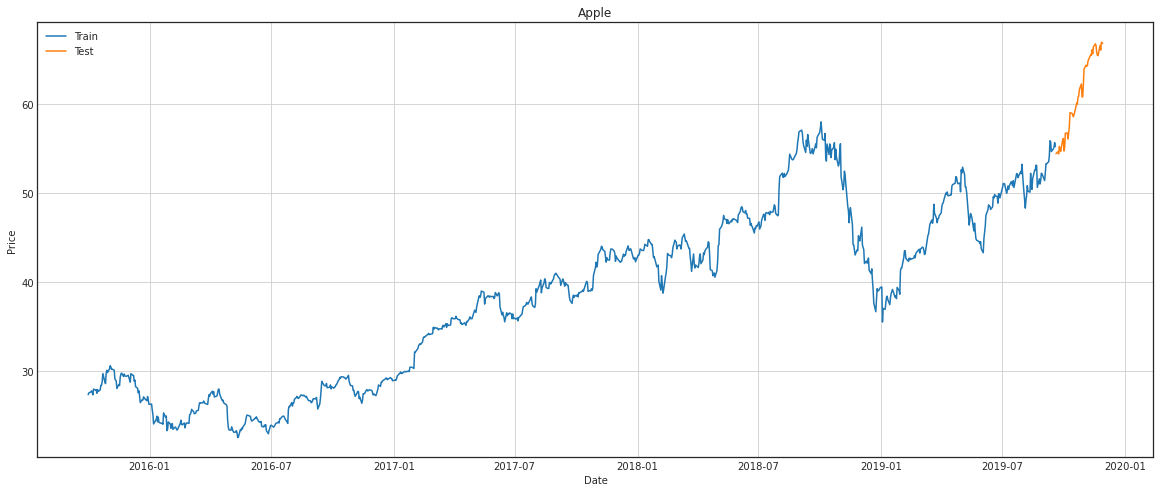

In [3]:
# Cтроим график
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(train['Close'], label="Train")
    plt.plot(test['Close'], label="Test")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Apple")
    plt.grid(True)
    plt.xlabel("Date")
    plt.ylabel("Price")

In [4]:
aapl['Close'].values.size

1049

## Скользящее среднее

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

In [5]:
def moving_average(series, n):
    return np.average(series[-n:])

In [6]:
moving_average(aapl['Close'].values, aapl['Close'].values.size)

39.463670183296315

In [7]:
aapl['Close'].values[-1]

66.8125

## Взвешенная средняя

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [8]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

In [9]:
weighted_average(aapl['Close'].values, [0.6, 0.2, 0.1, 0.07, 0.03])

65.88432472229005

In [10]:
aapl['Close'].values[-1]

66.8125

## Экспоненциальное сглаживание (модель Брауна)

$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $

In [11]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

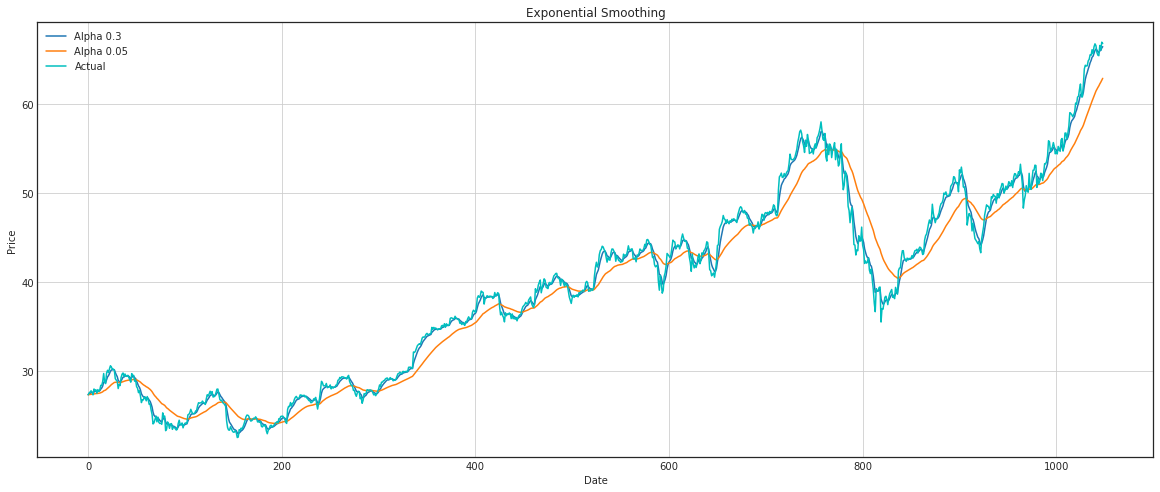

In [12]:
arr1 = exponential_smoothing(aapl['Close'], 0.3)
arr2 = exponential_smoothing(aapl['Close'], 0.05)
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(arr1, label="Alpha 0.3")
    plt.plot(arr2, label="Alpha 0.05")
    plt.plot(aapl['Close'].values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

## Двойное экспоненциальное сглаживание  (модель Хольта)

$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$

$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

$\hat{y}_{x+1} = \ell_x + b_x$

In [13]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

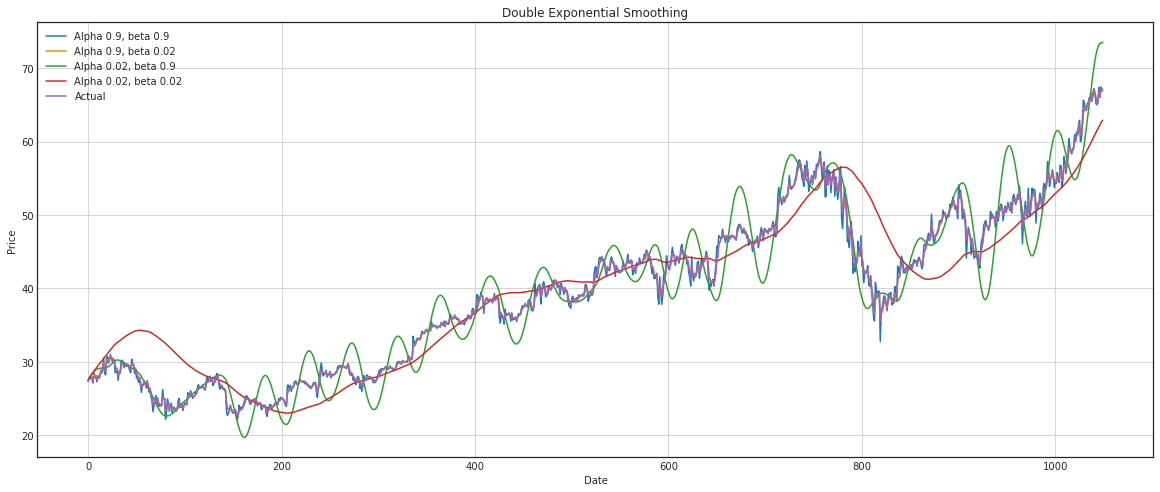

In [14]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(aapl['Close'], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(aapl['Close'].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

## Тройное экспоненциальное сглаживание  (модель Хольта — Винтерса)


$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$

$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$

$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$

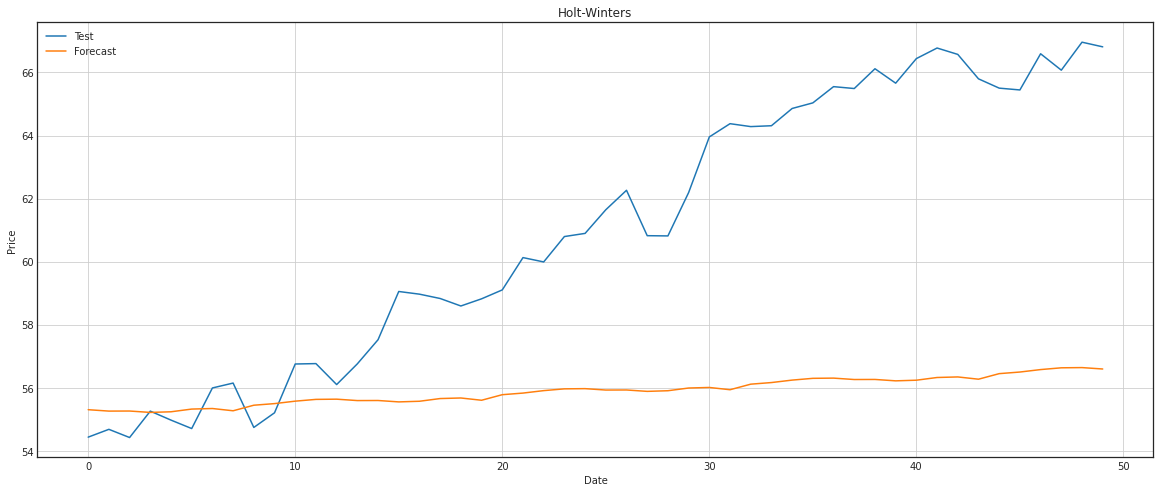

In [15]:
# На взгляд подбирал параметры модели. см. ниже
model = ExponentialSmoothing(train['Close'].values, trend='add', seasonal='add', seasonal_periods=12)
hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)
pred = hw_model.predict(start=1000, end=1049)

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(test['Close'].values, label = "Test")
    plt.plot(pred, label = "Forecast")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Holt-Winters")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

In [16]:
pred.size

50

In [17]:
print('Mean Absolute Error:', mean_absolute_error(test['Close'].values, pred))
print('Mean Squared Error:', mean_squared_error(test['Close'].values, pred))

Mean Absolute Error: 5.27233534649892
Mean Squared Error: 41.289487789544374


In [18]:
# Все варианты конфигов
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[12]) 

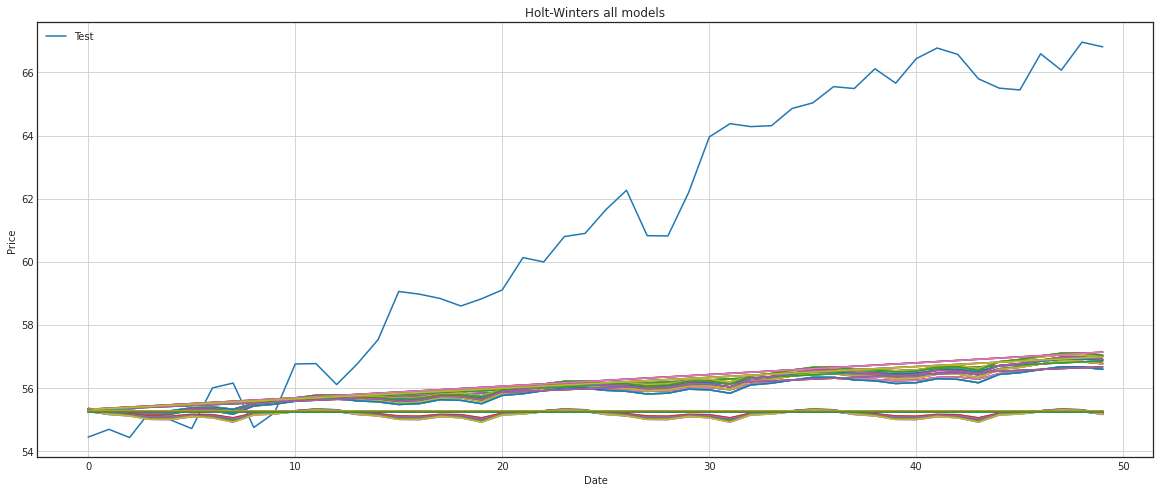

In [19]:
# Строим очень много графиков и смотрим какой набор параметров подойдет лучше
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(test['Close'].values, label = "Test")
    for j in range(len(cfg_list)):
        cg = cfg_list[j]
        t,d,s,p,b,r = cg
        model = ExponentialSmoothing(train['Close'].values, trend=t, seasonal=s, seasonal_periods=12)
        hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        pred = hw_model.predict(start=1000, end=1049)
        plt.plot(pred)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Holt-Winters all models")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)


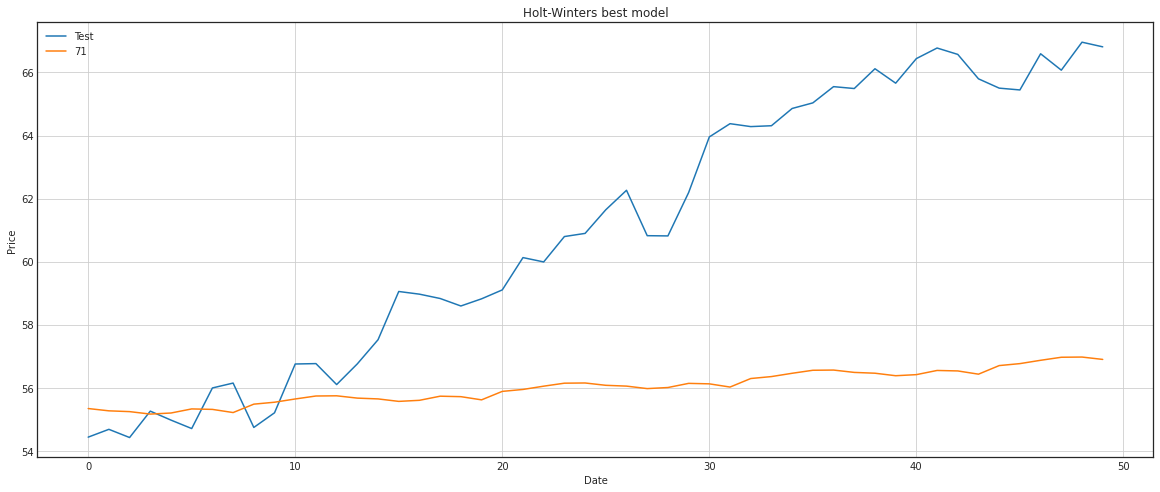

In [20]:
# Модель с лучшими параметрами
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(test['Close'].values, label = "Test")
    cg = cfg_list[43]
    t,d,s,p,b,r = cg
    model = ExponentialSmoothing(train['Close'].values, trend=t, seasonal=s, seasonal_periods=12)
    hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    pred = hw_model.predict(start=1000, end=1049)
    plt.plot(pred, label = j)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Holt-Winters best model")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)


In [21]:
print('Mean Absolute Error:', mean_absolute_error(test['Close'].values, pred))
print('Mean Squared Error:', mean_squared_error(test['Close'].values, pred))

Mean Absolute Error: 5.149673567021449
Mean Squared Error: 39.34879959966403


## Оценка свойств временного ряда

<Figure size 432x288 with 0 Axes>

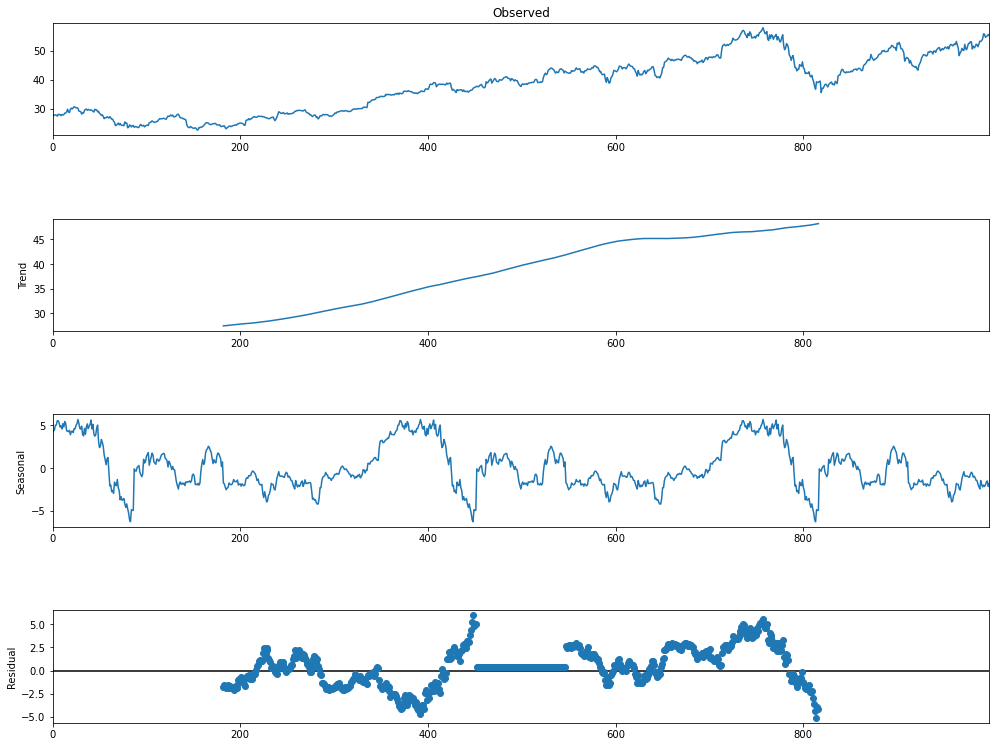

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
aapl_seasonal_decompose = seasonal_decompose(train['Close'].values, model='additive', freq=365)

plot_1 = plt.figure()  
plot_1 = aapl_seasonal_decompose.plot()  
plot_1.set_size_inches(15, 12)

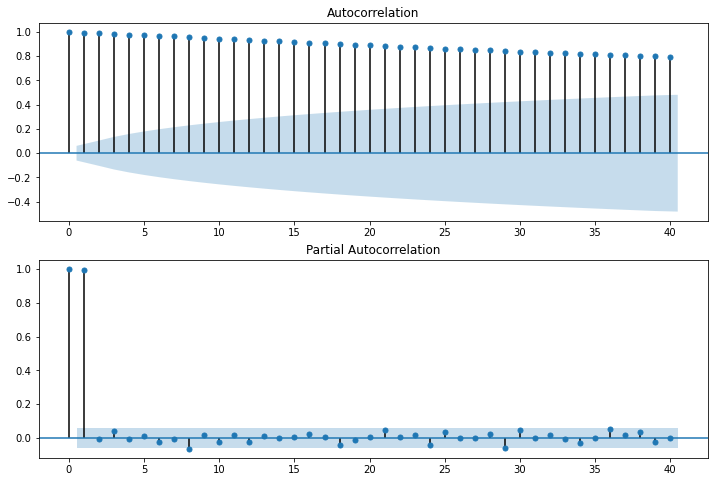

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(aapl['Close'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(aapl['Close'], lags=40, ax=ax2)
plt.show()
# Графики очень похожи на случайное блуждание. Предыдущее значение сильно связано с предыдущим

In [13]:
# тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC', maxlag = 20)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < 0.01:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [14]:
test_stationarity(train['Close'])

Results of Dickey-Fuller Test:
p-value = 0.8628. The series is likely non-stationary.
Test Statistic                  -0.635178
p-value                          0.862833
Lags Used                        8.000000
Number of Observations Used    990.000000
Critical Value (1%)             -3.436973
Critical Value (5%)             -2.864464
Critical Value (10%)            -2.568327
dtype: float64


In [15]:
# Преобразуем ряд, чтобы получить стационарные данные
first_diff = train['Close'] - train['Close'].shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.067904e+01
p-value                        3.984091e-19
Lags Used                      7.000000e+00
Number of Observations Used    9.900000e+02
Critical Value (1%)           -3.436973e+00
Critical Value (5%)           -2.864464e+00
Critical Value (10%)          -2.568327e+00
dtype: float64


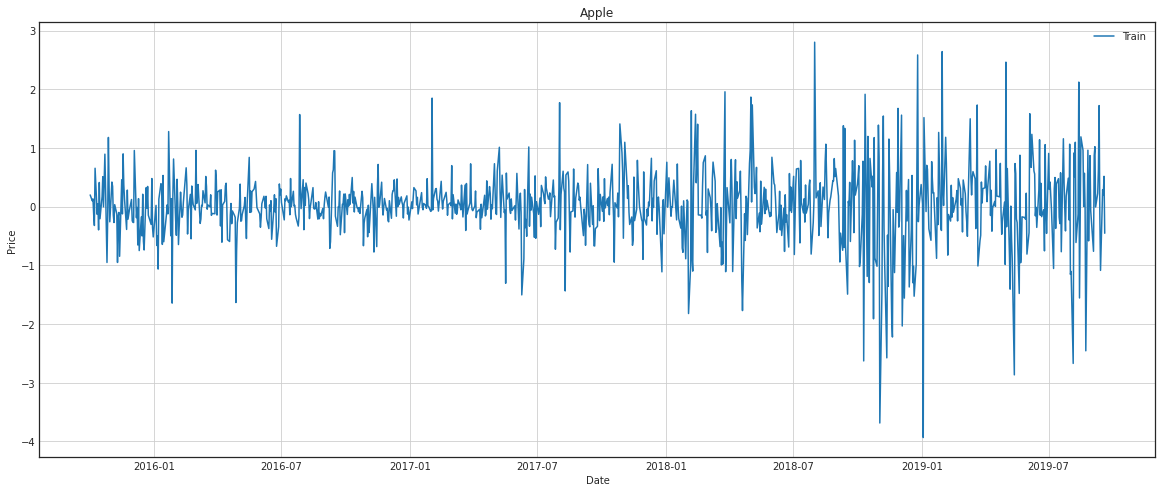

In [18]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(first_diff, label="Train")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Apple")
    plt.grid(True)
    plt.xlabel("Date")
    plt.ylabel("Price")

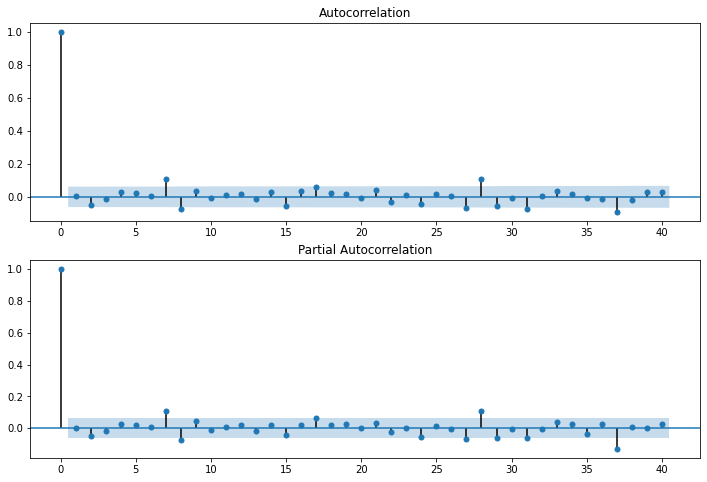

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)
plt.show()

## ARIMA model

In [ ]:
p = q = range(0, 6)
d = range(0, 3)
# Перебираем все комбинации p, q и q
pdq_arima = list(itertools.product(p, d, q))
len(pdq_arima)

In [92]:
# Информационный критерий Акаике (AIC) — критерий, применяющийся исключительно для выбора из нескольких статистических моделей.
warnings.filterwarnings("ignore") 
arima_aicmin = 1000000
for param in pdq_arima:
    try:
        arima_model=sm.tsa.ARIMA(train['Close'].values,
                   order=param)
        results_arima=arima_model.fit()
        
        if results_arima.aic < arima_aicmin:
            arima_aicmin = results_arima.aic
            best_param_aic = param 
        print(param, results_arima.aic)
    except:
        continue

(0, 0, 0) 7380.453425996085
(0, 0, 1) 6080.937442855689
(0, 0, 4) 3931.0690500229002
(0, 0, 5) 3493.7212472284123
(0, 1, 0) 1919.9285486256472
(0, 1, 1) 1921.921040313868
(0, 1, 2) 1921.8040590616338
(0, 1, 3) 1923.6523466032413
(0, 1, 4) 1924.3269790079894
(0, 1, 5) 1925.67744703674
(0, 2, 0) 2607.1430535622717
(0, 2, 1) 1927.6551056138678
(0, 2, 2) 1929.6429647822251
(0, 2, 3) 1929.5945446285978
(0, 2, 4) 1931.4575471851813
(0, 2, 5) 1932.0945575258884
(1, 0, 0) 1931.114727694974
(1, 0, 1) 1933.0811590793382
(1, 0, 2) 1933.2317916590841
(1, 0, 3) 1935.1367847222587
(1, 0, 4) 1935.6410325718712
(1, 0, 5) 1936.8534589923274
(1, 1, 0) 1921.9217515402338
(1, 1, 1) 1921.1043823208265
(1, 1, 2) 1923.7450766091158
(1, 1, 3) 1925.4738353730963
(1, 1, 4) 1924.292318500262
(1, 1, 5) 1921.302020966857
(1, 2, 0) 2354.7684996767716
(1, 2, 1) 1929.702163716869
(1, 2, 2) 1928.8121296663862
(1, 2, 3) 1930.1569856696856
(1, 2, 4) 1931.724138593389
(1, 2, 5) 1932.700607592853
(2, 0, 0) 1933.0841479721

In [105]:
print (arima_aicmin, best_param_aic)

1907.8855591813826 (5, 5, 5)


In [28]:
# Строим модель ARIMA
arima_model=sm.tsa.ARIMA(train['Close'].values,
                   order=(3, 1, 5))
results_arima=arima_model.fit()
print(results_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  998
Model:                 ARIMA(3, 1, 5)   Log Likelihood                -943.943
Method:                       css-mle   S.D. of innovations              0.623
Date:                Mon, 12 Oct 2020   AIC                           1907.886
Time:                        09:50:25   BIC                           1956.943
Sample:                             1   HQIC                          1926.533
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0282      0.023      1.232      0.218      -0.017       0.073
ar.L1.D.y     -0.8467      0.108     -7.851      0.000      -1.058      -0.635
ar.L2.D.y      0.6044      0.183      3.303      0.0

In [29]:
# Делаем предсказание
pred_arima = results_arima.forecast(50)

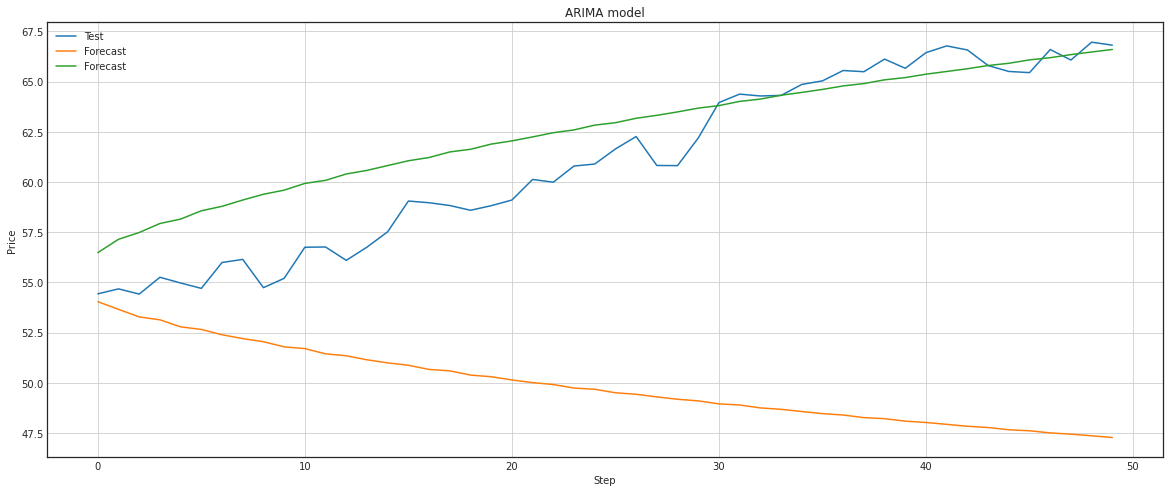

In [30]:
# Строим график. Где предказанные значения - это интервал и сравниваем с тестовыми данными
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(test['Close'].values, label = "Test")
    plt.plot(pred_arima[2][:,0], label = "Forecast")
    plt.plot(pred_arima[2][:,1], label = "Forecast")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("ARIMA model")
    plt.xlabel("Step")
    plt.ylabel("Price")
    plt.grid(True)

In [19]:
p = q = range(0, 6)
d = range(0, 3)
# Перебираем все комбинации p, q и q
pdq_arima = list(itertools.product(p, d, q))
len(pdq_arima)

108

In [20]:
# Информационный критерий Акаике (AIC) — критерий, применяющийся исключительно для выбора из нескольких статистических моделей.
warnings.filterwarnings("ignore") 
arima_aicmin = 1000000
for param in pdq_arima:
    try:
        arima_model=sm.tsa.ARIMA(first_diff,
                   order=param)
        results_arima=arima_model.fit()
        
        if results_arima.aic < arima_aicmin:
            arima_aicmin = results_arima.aic
            best_param_aic = param 
        print(param, results_arima.aic)
    except:
        continue

(0, 0, 0) 1919.9285486256472
(0, 0, 1) 1921.921040313868
(0, 0, 2) 1921.8040590616338
(0, 0, 3) 1923.6523466032413
(0, 0, 4) 1924.3269790079894
(0, 0, 5) 1925.67744703674
(0, 1, 0) 2607.1430535622717
(0, 1, 1) 1927.6551056138678
(0, 1, 2) 1929.6429647822251
(0, 1, 3) 1929.5945446285978
(0, 1, 4) 1931.4575471851813
(0, 1, 5) 1932.0945575258884
(0, 2, 0) 3682.246892721196
(0, 2, 1) 2614.4359674674934
(0, 2, 2) 1949.214057672146
(0, 2, 3) 1951.3506814107936
(0, 2, 4) 1953.0325451947037
(0, 2, 5) 1953.8729841999125
(1, 0, 0) 1921.9217515402338
(1, 0, 1) 1921.1043823208265
(1, 0, 2) 1923.7450766091158
(1, 0, 3) 1925.4738353730963
(1, 0, 4) 1924.292318500262
(1, 0, 5) 1921.302020966857
(1, 1, 0) 2354.7684996767716
(1, 1, 1) 1929.702163716869
(1, 1, 2) 1928.8121296663862
(1, 1, 3) 1930.1569856696856
(1, 1, 4) 1931.724138593389
(1, 1, 5) 1932.700607592853
(1, 2, 0) 3145.3056667888836
(1, 2, 4) 1951.49113181258
(2, 0, 0) 1921.676284448384
(2, 0, 1) 1923.5870459335858
(2, 0, 2) 1915.956357519403

In [21]:
print (arima_aicmin, best_param_aic)

1907.8855591813826 (3, 0, 5)


In [22]:
arima_model=sm.tsa.ARIMA(train['Close'].values,
                   order=(3, 1, 5))
results_arima=arima_model.fit()
print(results_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  998
Model:                 ARIMA(3, 1, 5)   Log Likelihood                -943.943
Method:                       css-mle   S.D. of innovations              0.623
Date:                Wed, 14 Oct 2020   AIC                           1907.886
Time:                        22:25:54   BIC                           1956.943
Sample:                             1   HQIC                          1926.533
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0282      0.023      1.232      0.218      -0.017       0.073
ar.L1.D.y     -0.8467      0.108     -7.851      0.000      -1.058      -0.635
ar.L2.D.y      0.6044      0.183      3.303      0.0

In [23]:
pred_arima = results_arima.forecast(50)

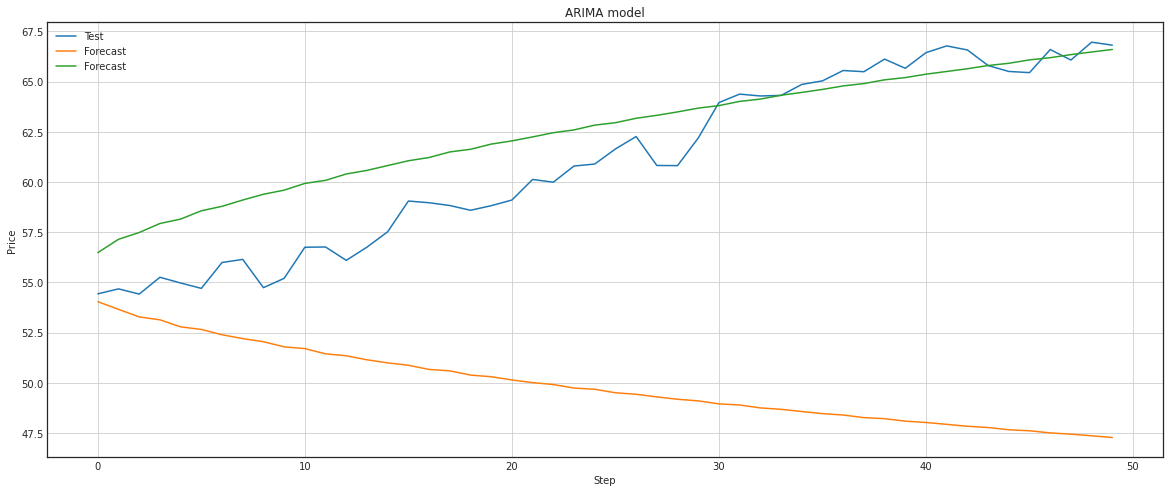

In [24]:
# Строим график. Где предказанные значения - это интервал и сравниваем с тестовыми данными
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(test['Close'].values, label = "Test")
    plt.plot(pred_arima[2][:,0], label = "Forecast")
    plt.plot(pred_arima[2][:,1], label = "Forecast")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("ARIMA model")
    plt.xlabel("Step")
    plt.ylabel("Price")
    plt.grid(True)

## SARIMAX model

In [45]:
p = q = d = range(0, 3)
s = [3, 6, 12]
# Перебираем все комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Перебираем комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))]

In [46]:
len(seasonal_pdq)

81

In [47]:
# Информационный критерий Акаике (AIC) — критерий, применяющийся исключительно для выбора из нескольких статистических моделей.
warnings.filterwarnings("ignore") 
sarimax_aicmin = 1000000

for param_seasonal in seasonal_pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(train['Close'].values,
        order=(3, 1, 5),
        seasonal_order=param_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < sarimax_aicmin:
            sarimax_aicmin = results.aic
            best_param_seasonal = param_seasonal
        print('SARIMAX{}x{} - AIC:{}'.format((3, 1, 5), param_seasonal, results.aic))
    except:
        continue

SARIMAX(3, 1, 5)x(0, 0, 0, 3) - AIC:1903.7897380930176
SARIMAX(3, 1, 5)x(0, 0, 0, 6) - AIC:1903.7897380930176
SARIMAX(3, 1, 5)x(0, 0, 0, 12) - AIC:1903.7897380930176
SARIMAX(3, 1, 5)x(0, 0, 1, 6) - AIC:1899.0758910239279
SARIMAX(3, 1, 5)x(0, 0, 1, 12) - AIC:1888.5667139840261
SARIMAX(3, 1, 5)x(0, 0, 2, 6) - AIC:1889.895656431765
SARIMAX(3, 1, 5)x(0, 0, 2, 12) - AIC:1870.1958930323108
SARIMAX(3, 1, 5)x(0, 1, 0, 3) - AIC:1931.9731374521405
SARIMAX(3, 1, 5)x(0, 1, 0, 6) - AIC:2171.982995344788
SARIMAX(3, 1, 5)x(0, 1, 0, 12) - AIC:2501.6361642307324
SARIMAX(3, 1, 5)x(0, 1, 1, 6) - AIC:1906.7076594775035
SARIMAX(3, 1, 5)x(0, 1, 1, 12) - AIC:3025.5887201328164
SARIMAX(3, 1, 5)x(0, 1, 2, 6) - AIC:1904.0990710687754
SARIMAX(3, 1, 5)x(0, 1, 2, 12) - AIC:2921.470611565006
SARIMAX(3, 1, 5)x(0, 2, 0, 3) - AIC:2305.041293572264
SARIMAX(3, 1, 5)x(0, 2, 0, 6) - AIC:2816.1556101803712
SARIMAX(3, 1, 5)x(0, 2, 0, 12) - AIC:3436.9821311187043
SARIMAX(3, 1, 5)x(0, 2, 1, 6) - AIC:2194.813139003165
SARIMAX(

In [48]:
print (sarimax_aicmin, (3, 1, 5), best_param_seasonal)

1870.1958930323108 (3, 1, 5) (0, 0, 2, 12)


In [49]:
mod = sm.tsa.statespace.SARIMAX(train['Close'].values,
order=(3, 1, 5),
seasonal_order=(0, 0, 1, 12),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8594      0.103     -8.332      0.000      -1.062      -0.657
ar.L2          0.5772      0.177      3.252      0.001       0.229       0.925
ar.L3          0.8129      0.102      7.934      0.000       0.612       1.014
ma.L1          0.8795      0.104      8.472      0.000       0.676       1.083
ma.L2         -0.6174      0.180     -3.423      0.001      -0.971      -0.264
ma.L3         -0.8829      0.112     -7.860      0.000      -1.103      -0.663
ma.L4          0.0514      0.034      1.527      0.127      -0.015       0.117
ma.L5          0.1211      0.025      4.927      0.000       0.073       0.169
ma.S.L12      -0.0106      0.029     -0.366      0.714      -0.067       0.046
sigma2         0.3929      0.010     37.972      0.000       0.373       0.413


In [54]:
# Делаем предсказание
pred = results.get_forecast(steps=50)
pred_c = pred.conf_int()

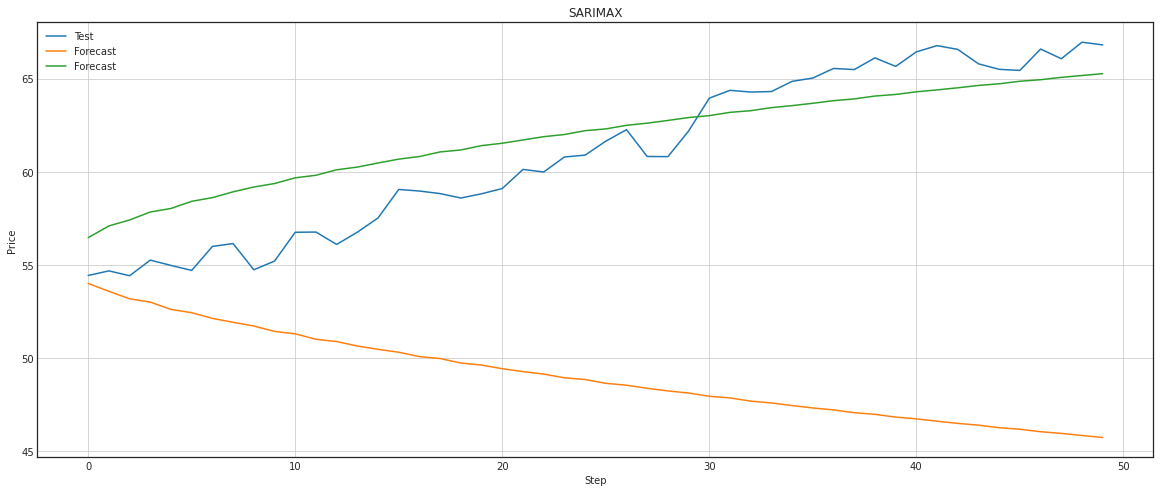

In [55]:
# Строим график. Где предказанные значения - это интервал и сравниваем с тестовыми данными
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(test['Close'].values, label = "Test")
    plt.plot(pred_c[:,0], label = "Forecast")
    plt.plot(pred_c[:,1], label = "Forecast")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("SARIMAX")
    plt.xlabel("Step")
    plt.ylabel("Price")
    plt.grid(True)

In [57]:
p = q = d = range(0, 2)
s = [6, 12]
# Перебираем все комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Перебираем комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))]

In [59]:
# Информационный критерий Акаике (AIC) — критерий, применяющийся исключительно для выбора из нескольких статистических моделей.
warnings.filterwarnings("ignore") 
sarimax_aicmin_2 = 1000000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['Close'].values,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < sarimax_aicmin_2:
                sarimax_aicmin_2 = results.aic
                best_param_seasonal = param_seasonal
                best_param = param
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:10177.38643085288
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10177.38643085288
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:8809.575682861796
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8805.21482240965
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:3653.7818701797396
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4401.304276964049
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:3631.9294682424074
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4335.853405228243
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:3649.4832906795004
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4391.895777316652
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:3642.797683225832
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4376.735465295321
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:3634.1377751244227
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4339.871638017951
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:3629.5562088278552
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4336.993226335265
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:8812.04210404883
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8812.04210404883
ARIMA(0, 0, 1)x(0

In [60]:
print (sarimax_aicmin_2, best_param, best_param_seasonal)

1906.2635573612388 (0, 1, 0) (0, 0, 1, 12)


In [5]:
mod = sm.tsa.statespace.SARIMAX(train['Close'].values,
order=(5, 2, 5),
seasonal_order=(5, 2, 5, 12),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

c:\users\gafed\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.2071      0.378     -5.836      0.000      -2.948      -1.466
ar.L2         -2.3546      0.767     -3.068      0.002      -3.859      -0.850
ar.L3         -1.3749      0.743     -1.851      0.064      -2.831       0.081
ar.L4         -0.3066      0.355     -0.864      0.388      -1.002       0.389
ar.L5          0.0403      0.046      0.877      0.381      -0.050       0.130
ma.L1          1.5383      0.309      4.982      0.000       0.933       2.144
ma.L2          0.8689      0.412      2.108      0.035       0.061       1.677
ma.L3         -1.0280      0.309     -3.332      0.001      -1.633      -0.423
ma.L4         -1.6743      0.407     -4.117      0.000      -2.471      -0.877
ma.L5         -0.5622      0.480     -1.170      0.242      -1.504       0.379
ar.S.L12      -1.5831      0.185     -8.558      0.0

In [6]:
# Делаем предсказание
pred = results.get_forecast(steps=50)
pred_c = pred.conf_int()

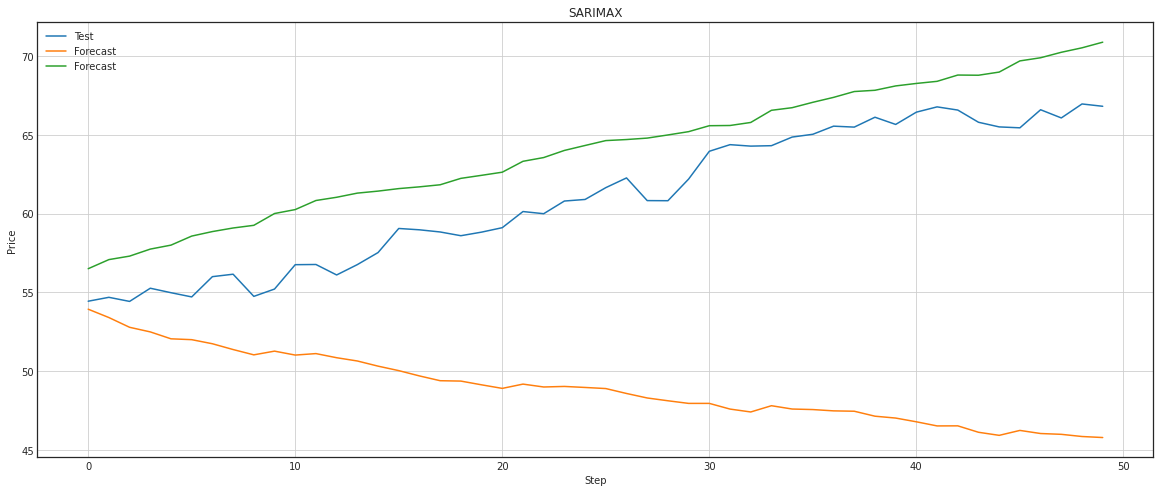

In [7]:
# Строим график. Где предказанные значения - это интервал и сравниваем с тестовыми данными

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(test['Close'].values, label = "Test")
    plt.plot(pred_c[:,0], label = "Forecast")
    plt.plot(pred_c[:,1], label = "Forecast")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("SARIMAX")
    plt.xlabel("Step")
    plt.ylabel("Price")
    plt.grid(True)